In [1]:
%reload_ext autoreload
%autoreload 2
# !pip install --upgrade transformers 
# which python
# !pip install -q transformers
# !pip install -q datasets
# !pip install -q evaluate
# !pip install -q accelerate
# !pip install -q gluonts ujson

# Tutoial directly gotten from https://huggingface.co/blog/time-series-transformers


In [2]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "tourism_monthly")

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# train_example = dataset['train'][0]
# print(train_example.keys())
# validation_example = dataset['validation'][0]
# test_example = dataset['test'][0]
# print(dataset['train'][0]["start"])
# print(len(dataset['train'][0]["target"]))
# print(dataset['train'][4]["start"])
# print(len(dataset['train'][4]["target"]))

In [4]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [5]:
from functools import partial
train_dataset = dataset["train"]
test_dataset = dataset["test"]
    
freq = "1M"
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [6]:
from gluonts.time_feature import get_lags_for_frequency
from gluonts.time_feature import time_features_from_frequency_str

# The look back window, in this case how many days we consider 
lags_sequence = get_lags_for_frequency(freq)
time_features = time_features_from_frequency_str(freq)

print(lags_sequence)
print(time_features)

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]
[<function month_of_year at 0x00000202146D3E20>]


In [7]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

prediction_length = 24
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # # How many inputs the model take into account when 
    context_length=prediction_length * 2, 
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,# TODO: understand this 
    # day of year, day of months, and day of week
    num_time_features=len(time_features),
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],# TODO: understand this 
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32, 
)

model = TimeSeriesTransformerForPrediction(config)

In [8]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # We use days of week, days of months, and days of years in this case 
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            # AddAgeFeature(
            #     target_field=FieldName.TARGET,
            #     output_field=FieldName.FEAT_AGE,
            #     pred_length=config.prediction_length,
            #     log_scale=True,
            # ),
            # # step 6: vertically stack all the temporal features into the key FEAT_TIME
            # VstackFeatures(
            #     output_field=FieldName.FEAT_TIME,
            #     input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
            #     + (
            #         [FieldName.FEAT_DYNAMIC_REAL]
            #         if config.num_dynamic_real_features > 0
            #         else []
            #     ),
            # ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )
    
    
    
# transformation = create_transformation(freq, config)
# transformed_data = transformation.apply(train_dataset, is_train=False)
# print(next(iter(transformed_data))["time_features"].shape)
# print(train_dataset[0].keys())

# print(next(iter(transformed_data))["time_features"][0])
# # print(train_dataset[0]["target"])
# time_features_from_frequency_str(freq)[0](train_dataset[0]["start"])

In [9]:


from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]
    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )
    
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [10]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)
# i = 0
# for j in test_dataloader:
#     i+=1
#     print(j.keys())
#     print(j["past_time_features"].shape)
#     print(j["past_values"].shape)
#     print(j["past_observed_mask"].shape)
#     print(j["future_time_features"].shape)
#     print(j["static_categorical_features"].shape)

# print(len(test_dataset[0]["target"]))

In [11]:

batch = next(iter(train_dataloader))
# perform forward pass
print(batch.keys())
# dict_keys(['past_time_features', 'past_values', 'past_observed_mask', 'future_time_features', 'static_categorical_features', 'future_values', 'future_observed_mask'])
# dict_keys(['past_time_features', 'past_values', 'past_observed_mask', 'future_time_features', 'static_categorical_features', 'future_values', 'future_observed_mask'])

outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)
print("Loss:", outputs.loss.item())


dict_keys(['past_time_features', 'past_values', 'past_observed_mask', 'future_time_features', 'static_categorical_features', 'future_values', 'future_observed_mask'])
Loss: 9.17088794708252


In [12]:
from accelerate import Accelerator
from torch.optim import AdamW
import torch.optim.lr_scheduler as lr_scheduler


accelerator = Accelerator()
device = accelerator.device

def train(model, data_loader, epoch):
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    model, optimizer, data_loader = accelerator.prepare(
        model,
        optimizer,
        data_loader,
    )
    model.train()
    print("-------------TRAINING START-------------")
    print("Training with epoch: " + str(epoch))
    for epoch in range(epoch):
        for idx, batch in enumerate(data_loader):
            optimizer.zero_grad()
            outputs = model(
                static_categorical_features=batch["static_categorical_features"].to(device)
                if config.num_static_categorical_features > 0
                else None,
                static_real_features=batch["static_real_features"].to(device)
                if config.num_static_real_features > 0
                else None,
                past_time_features=batch["past_time_features"].to(device),
                past_values=batch["past_values"].to(device),
                future_time_features=batch["future_time_features"].to(device),
                future_values=batch["future_values"].to(device),
                past_observed_mask=batch["past_observed_mask"].to(device),
                future_observed_mask=batch["future_observed_mask"].to(device),
            )
            loss = outputs.loss

            # Backpropagation
            accelerator.backward(loss)
            optimizer.step()

            if idx % 100 == 0:
                print(loss.item())
        scheduler.step()
    print("-------------TRAINING END-------------")
    return model
    

In [13]:

model = train(model, train_dataloader, 5)

-------------TRAINING START-------------
Training with epoch: 5
9.071770668029785
8.262934684753418
7.657726764678955
7.281899929046631
7.302473545074463
-------------TRAINING END-------------


In [14]:
def evaluate(model, data_loader):
    model.eval()

    forecasts = []

    for batch in data_loader:
        outputs = model.generate(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
        )
        forecasts.append(outputs.sequences.cpu().numpy())
        
    forecasts = np.vstack(forecasts)
    return forecasts


In [15]:
def evaluate(model, data_loader):
    model.eval()

    forecasts = []

    for batch in data_loader:
        outputs = model.generate(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
        )
        forecasts.append(outputs.sequences.cpu().numpy())
        
    forecasts = np.vstack(forecasts)
    return forecasts


In [16]:

forecasts = evaluate(model, test_dataloader)

In [17]:
# i = 0
# for _ in train_dataloader:
#     print(_["past_time_features"][0])
#     i+=1
    
# len(test_target)
forecasts

array([[[  6975.993 ,   5801.7676,   4320.7056, ...,   3325.9565,
           5497.949 ,   6673.063 ],
        [  8782.631 ,   7099.346 ,   4670.851 , ...,   3125.8955,
           5530.609 ,   6818.4976],
        [  8670.354 ,   5034.9556,   4682.9043, ...,   3340.9734,
           3840.2576,   8339.666 ],
        ...,
        [  7120.6543,   6063.0664,   4913.6646, ...,   4800.6997,
           6271.566 ,   7865.21  ],
        [  6221.8037,   5407.438 ,   3702.1536, ...,   6856.6875,
           6806.3955,   9158.492 ],
        [  8023.788 ,   5538.6484,   3081.6367, ...,   2893.3232,
           5249.5527,  13517.366 ]],

       [[182618.73  , 183553.6   , 169649.47  , ...,  95239.51  ,
         124079.68  , 161844.    ],
        [185257.95  , 194467.3   , 169579.8   , ..., 139394.9   ,
         163975.69  , 216044.06  ],
        [157786.4   , 163761.28  , 108646.31  , ...,  82343.195 ,
         151279.39  , 185900.36  ],
        ...,
        [167448.78  , 206602.86  , 204980.69  , ..., 1

In [23]:
from evaluate import load
from gluonts.time_feature import get_seasonality
def calculate(forecasts, dataset):

    mse_metric = load("evaluate-metric/mse")
    mase_metric = load("evaluate-metric/mase")
    smape_metric = load("evaluate-metric/smape")

    forecast_median = np.median(forecasts, 1)

    mse_metrics = []
    mase_metrics = []
    smape_metrics = []
    for item_id, ts in enumerate(dataset):
        training_data = ts["target"][:-prediction_length]
        ground_truth = ts["target"][-prediction_length:]
        mse = mse_metric.compute(
            predictions=forecast_median[item_id], 
            references=np.array(ground_truth)
            )
        mse_metrics.append(mse["mse"])
        
        mase = mase_metric.compute(
            predictions=forecast_median[item_id], 
            references=np.array(ground_truth), 
            training=np.array(training_data), 
            periodicity=get_seasonality(freq))
        mase_metrics.append(mase["mase"])
        
        smape = smape_metric.compute(
            predictions=forecast_median[item_id], 
            references=np.array(ground_truth), 
        )
        smape_metrics.append(smape["smape"])
    
    return mse_metrics, mase_metrics, smape_metrics

mse_metrics, mase_metrics, smape_metrics = calculate(forecasts, test_dataset)   
print(f"Test MSE: {np.mean(mse_metrics)}")
print(f"Test MASE: {np.mean(mase_metrics)}")
print(f"Test sMAPE: {np.mean(smape_metrics)}")

# TODO: Normalize this and see how it goes 

Test MSE: 95925524.58048363
Test MASE: 2.2951642757037165
Test sMAPE: 0.252154941546405


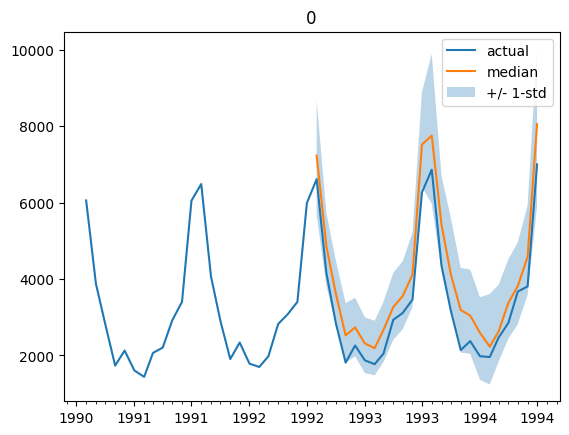

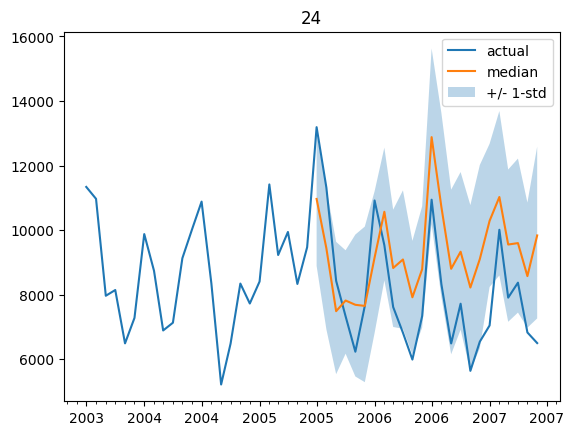

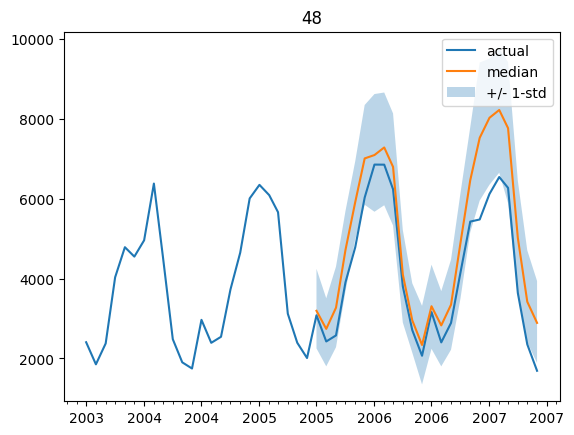

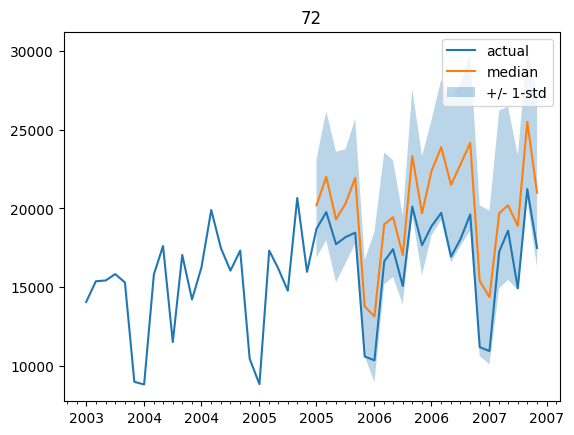

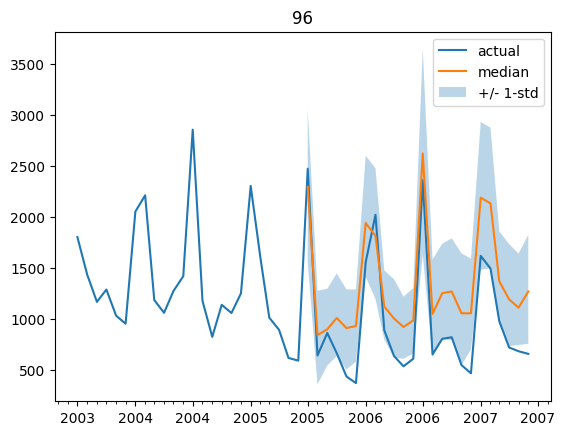

366

In [18]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 

def plot(ts_index, forecasts):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    plt.title(str(ts_index))
    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()
    
plot(0, forecasts)
plot(prediction_length, forecasts)
plot(prediction_length * 2, forecasts)
plot(prediction_length * 3, forecasts)
plot(prediction_length * 4, forecasts)


len(forecasts)

In [19]:
import random 
def plot_randomly(forecasts):
    plot(random.randint(0, len(forecasts) - 1), forecasts)
    

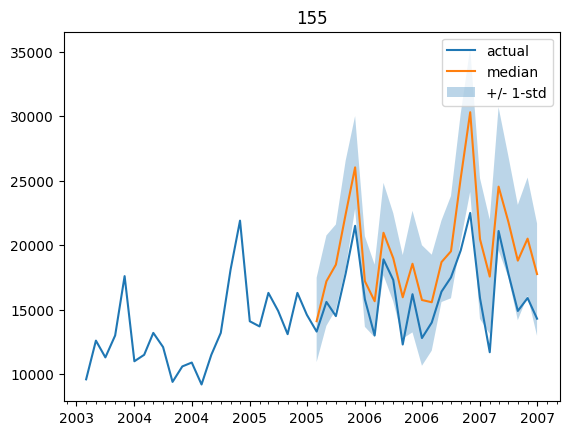

In [20]:
plot_randomly(forecasts)


In [21]:

# # Try with epoch of 20 

# TODO: does the model's parameters reset when I pass it in the training loop again? FIND OUT
model = TimeSeriesTransformerForPrediction(config)
model = train(model, train_dataloader, 10)

-------------TRAINING START-------------
Training with epoch: 10
9.37700366973877
8.612318992614746
7.415805816650391
7.7810378074646
7.374942302703857
7.108980655670166
6.935500621795654
6.712017059326172
6.78800630569458
6.851029872894287
-------------TRAINING END-------------


In [22]:

forecasts_test = evaluate(model, test_dataloader) 

In [23]:

train_dataloader_eval = create_test_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=64,
)
forecasts_train = evaluate(model, train_dataloader_eval)

In [24]:

mse_metrics_train, mase_metrics_train, smape_metrics_train = calculate(forecasts_train, train_dataset)   

NameError: name 'calculate' is not defined

In [ ]:

 
mse_metrics_test, mase_metrics_test, smape_metrics_test = calculate(forecasts_test, test_dataset)  

In [ ]:

print(f"Train MSE: {np.mean(mse_metrics_train)}")
print(f"Test MSE: {np.mean(mse_metrics_test)}")
print(f"Train MASE: {np.mean(mase_metrics_train)}")
print(f"Test MASE: {np.mean(mase_metrics_test)}")
print(f"Train sMAPE: {np.mean(smape_metrics_train)}")
print(f"Test sMAPE: {np.mean(smape_metrics_test)}")

Train MSE: 0.1016107306770977
Test MSE: 0.07031509309540471
Train MASE: 0.9560396630533824
Test MASE: 1.1003828219742027
Train sMAPE: 0.27435744239020354
Test sMAPE: 0.23152500989246366


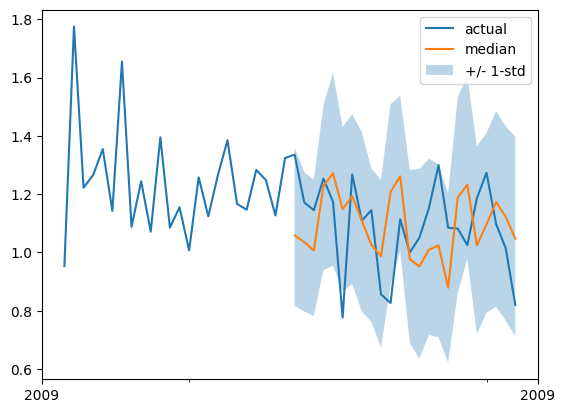

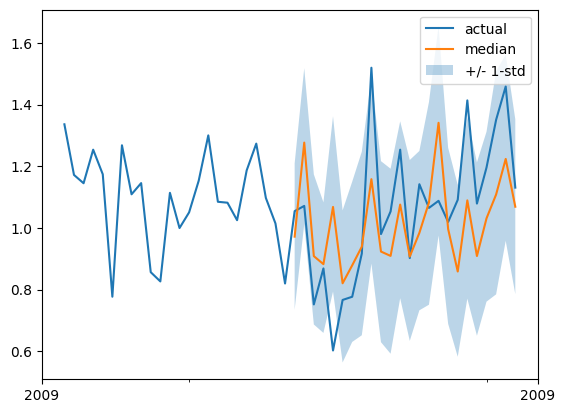

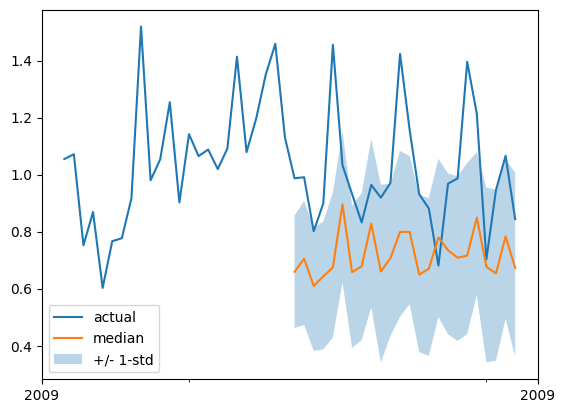

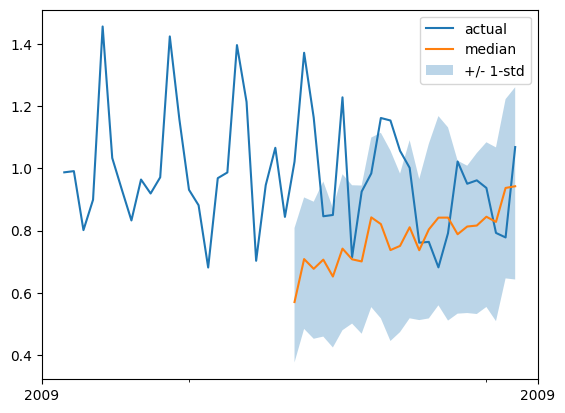

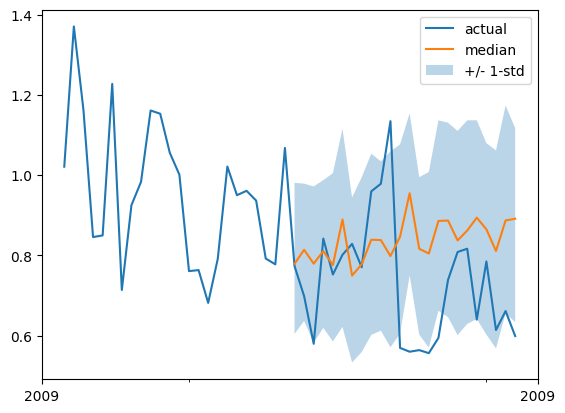

In [ ]:

plot(0, forecasts_train)
plot(prediction_length, forecasts_train)
plot(prediction_length * 2, forecasts_train)
plot(prediction_length * 3, forecasts_train)
plot(prediction_length * 4, forecasts_train)

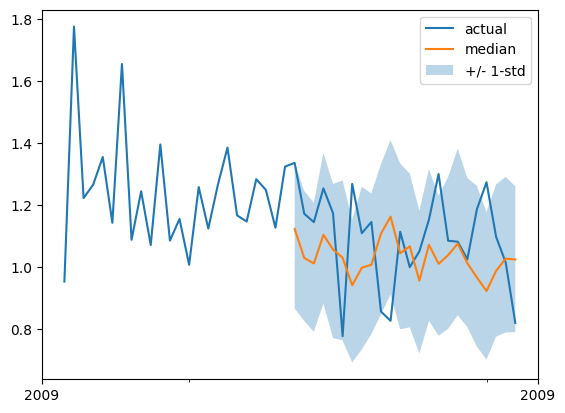

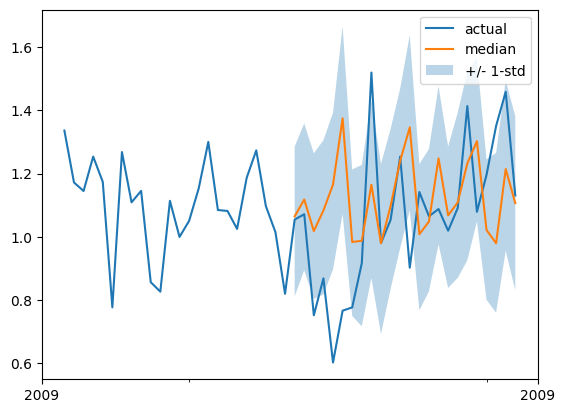

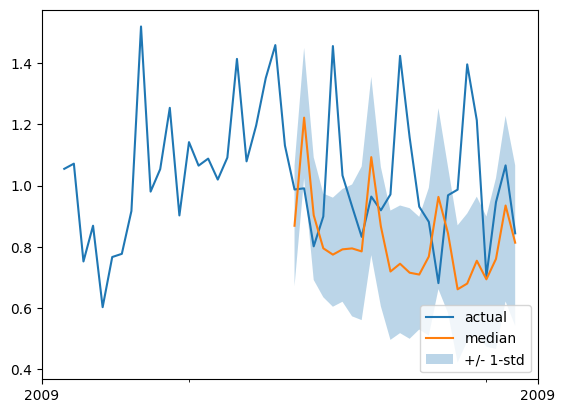

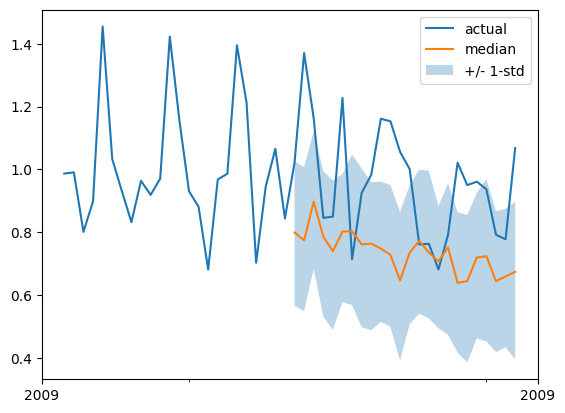

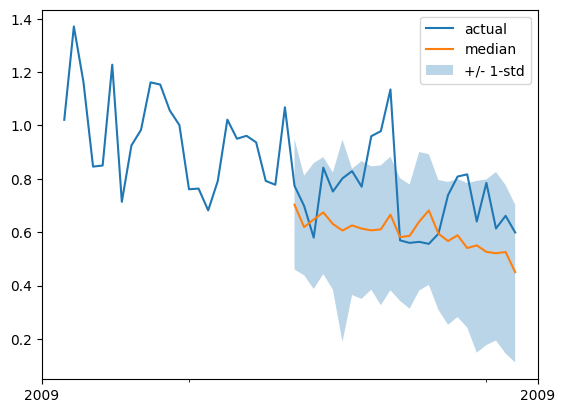

In [ ]:

plot(0, forecasts_test)
plot(prediction_length, forecasts_test)
plot(prediction_length * 2, forecasts_test)
plot(prediction_length * 3, forecasts_test)
plot(prediction_length * 4, forecasts_test)